In [43]:
#Import the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


In [44]:
#Load the datasets

circle_data = np.asarray(pd.read_csv('data/circles.csv',header=None,skiprows=1))
circle_data = circle_data[:,1:]
swiss_data = np.asarray(pd.read_csv('data/swr.csv',header=None,skiprows=1))
swiss_data = swiss_data[:,1:]

#Set up the data into the X and Y sets

X_circle = circle_data[:,:-1]
Y_circle = circle_data[:,-1]

X_swiss = swiss_data[:,:-1]
Y_swiss = swiss_data[:,-1]



C:\Users\chees\AppData\Local\Temp\ipykernel_10080\1226476416.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


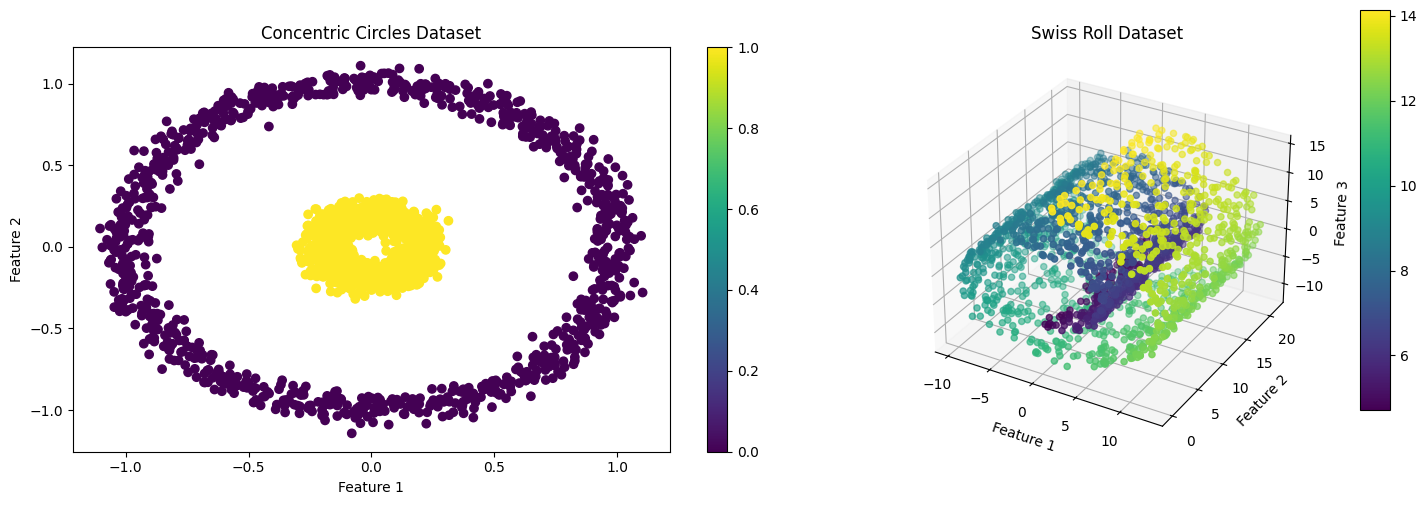

In [45]:

#See what this dataset looks like


#Visualize datasets
fig = plt.figure(figsize=(15, 5))

#plot the 
plt.subplot(1, 2, 1)
plt.scatter(X_circle[:, 0], X_circle[:, 1], c=Y_circle)
plt.title("Concentric Circles Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar()

#plot swiss roll data
ax = plt.subplot(1, 2, 2, projection='3d')
sc = ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=Y_swiss, cmap='viridis')
ax.set_title("Swiss Roll Dataset")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")

#color bar for swiss roll
ax2 = fig.add_axes([0.91,0.2,0.02,0.8])
norm = Normalize(vmin=Y_swiss.min(), vmax=Y_swiss.max())
sm = ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=ax2)

plt.tight_layout()
plt.show()



In [46]:
# Setting up a Kernel PCA class

class KernelPCA_RBF:
    def __init__(self, n_components=2, sigma=1.0):
        self.n_components = n_components
        self.sigma = sigma
        self.X = None
        self.kernel_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def rbf_kernel(self, x1, x2):
        return np.exp(-(1 / (2 * self.sigma**2)) * np.linalg.norm(x1 - x2, axis=0)**2)
    
    def compute_kernel_matrix(self, X):
        n = X.shape[0]
        #K = np.zeros((n, n))
        # for i in range(n):
        #     for j in range(n):
        #         K[i, j] = self.rbf_kernel(X[i], X[j])
        # return K
        col = X.T.reshape((X.shape[1], -1, 1))
        row = X.T.reshape((X.shape[1], 1, -1))

        K = self.rbf_kernel(col, row)
        return K

    def center_kernel_matrix(self, Kernel):
        n = Kernel.shape[0]
        ones_mat = np.ones((n,n))/n
        K_tilda = Kernel - np.dot(ones_mat,Kernel) - np.dot(Kernel,ones_mat) + np.dot(np.dot(ones_mat,Kernel),ones_mat)
        return K_tilda

    def fit(self, X):
        self.X = X
        self.kernel_matrix = self.compute_kernel_matrix(X)
        self.kernel_matrix = self.center_kernel_matrix(self.kernel_matrix)
        eigenvalues, eigenvectors = np.linalg.eigh(self.kernel_matrix)
        #Sort eigenvectors and eigenvalues in descending order
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[indices]
        self.eigenvectors = eigenvectors[:, indices]
    
    def transform(self):
        return self.eigenvectors[:, :self.n_components]

    def fit_transform(self, X):
        self.fit(X)
        return self.transform()

# Class for doing the standard version of PCA
class KernelPCA_Linear: #same as doing normal PCA
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.X = None
        self.kernel_matrix = None
        self.eigenvalues = None
        self.eigenvectors = None
    
    def linear_kernel(self, x1, x2):
        return np.dot(x1,x2)
    
    def compute_kernel_matrix(self, X):
        n = X.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self.linear_kernel(X[i], X[j])
        return K
    
    def center_kernel_matrix(self, Kernel):
        n = Kernel.shape[0]
        ones_mat = np.ones((n,n))/n
        K_tilda = Kernel - np.dot(ones_mat,Kernel) - np.dot(Kernel,ones_mat) + np.dot(np.dot(ones_mat,Kernel),ones_mat)
        return K_tilda

    def fit(self, X):
        self.X = X
        self.kernel_matrix = self.compute_kernel_matrix(X)
        self.kernel_matrix = self.center_kernel_matrix(self.kernel_matrix)
        eigenvalues, eigenvectors = np.linalg.eigh(self.kernel_matrix)
        #Sort eigenvectors and eigenvalues in descending order
        indices = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[indices]
        self.eigenvectors = eigenvectors[:, indices]
    
    def transform(self):
        return self.eigenvectors[:, :self.n_components]
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform()

In [47]:
#Okay lets use this kernel PCA on the circle dataset

sigma_list_circ = [0.25,0.5,1]

#First Sigma value .01
kpca_sig1 = KernelPCA_RBF(n_components=2, sigma=sigma_list_circ[0])
#Second Sigma value .1
kpca_sig2 = KernelPCA_RBF(n_components=2, sigma=sigma_list_circ[1])
#Third Sigma value 1
kpca_sig3 = KernelPCA_RBF(n_components=2, sigma=sigma_list_circ[2])
#Normal PCA
pca_lin = KernelPCA_Linear(n_components=2)
#Transforming the Cirlce datasets
X_kpca_sig1 = kpca_sig1.fit_transform(X_circle)
X_kpca_sig2 = kpca_sig2.fit_transform(X_circle)
X_kpca_sig3 = kpca_sig3.fit_transform(X_circle)
X_pca = pca_lin.fit_transform(X_circle)



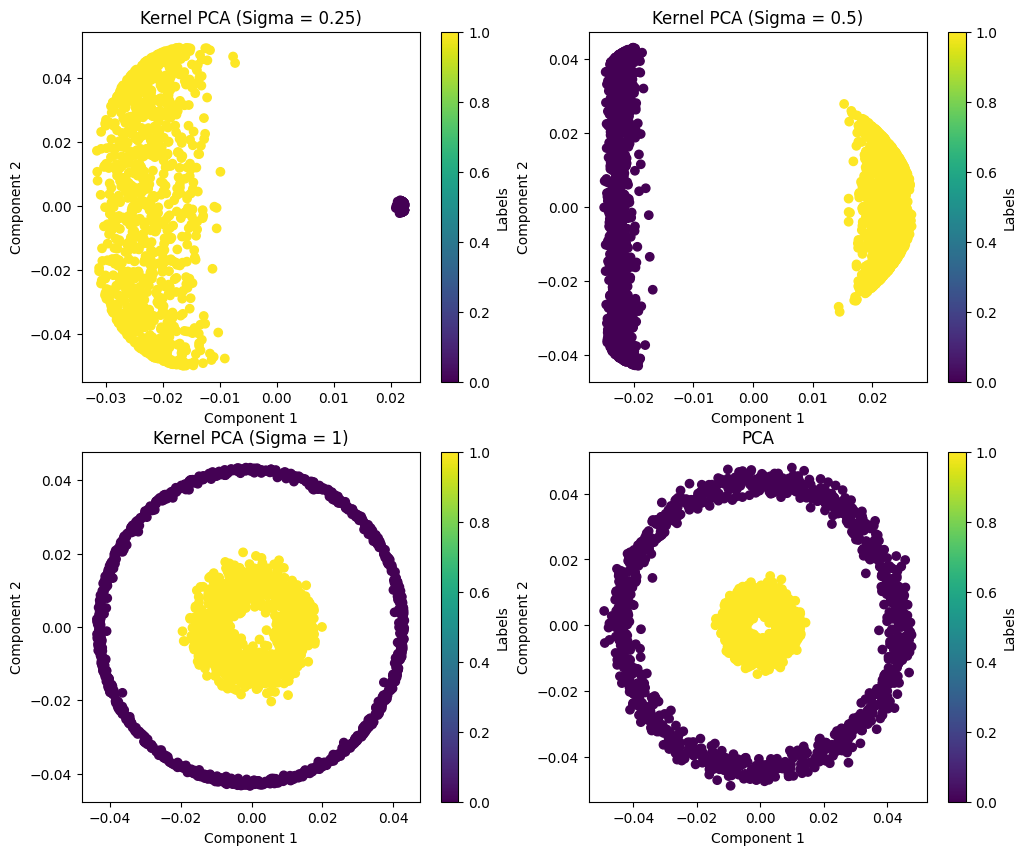

In [48]:

#Plot the results as a single figure
plt.figure(figsize=(12, 10))

# Plot Kernel PCA with sigma = 0.1
plt.subplot(2, 2, 1)
plt.scatter(X_kpca_sig1[:, 0], X_kpca_sig1[:, 1], c=Y_circle)
plt.title(f"Kernel PCA (Sigma = {sigma_list_circ[0]})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

# Plot Kernel PCA with sigma = 1
plt.subplot(2, 2, 2)
plt.scatter(X_kpca_sig2[:, 0], X_kpca_sig2[:, 1], c=Y_circle)
plt.title(f"Kernel PCA (Sigma = {sigma_list_circ[1]})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

# Plot Kernel PCA with sigma = 10
plt.subplot(2, 2, 3)
plt.scatter(X_kpca_sig3[:, 0], X_kpca_sig3[:, 1], c=Y_circle)
plt.title(f"Kernel PCA (Sigma = {sigma_list_circ[2]})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

# Plot regular PCA
plt.subplot(2, 2, 4)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_circle)
plt.title(f"PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

plt.savefig('KPCA_CircleSet.png',dpi=200)


In [49]:
#Okay lets use this kernel PCA on the circle dataset

sig_list_swiss = [0.1,2,3]

#First Sigma value .1
kpca_sig1 = KernelPCA_RBF(n_components=2, sigma=sig_list_swiss[0])
#Second Sigma value 10
kpca_sig2 = KernelPCA_RBF(n_components=2, sigma=sig_list_swiss[1])
#Third Sigma value 100
kpca_sig3 = KernelPCA_RBF(n_components=2, sigma=sig_list_swiss[2])
#Normal PCA
pca_lin = KernelPCA_Linear(n_components=2)

#Transforming the swiss roll dataset
X_kpca_sig1 = kpca_sig1.fit_transform(X_swiss)
X_kpca_sig2 = kpca_sig2.fit_transform(X_swiss)
X_kpca_sig3 = kpca_sig3.fit_transform(X_swiss)
X_pca = pca_lin.fit_transform(X_swiss)


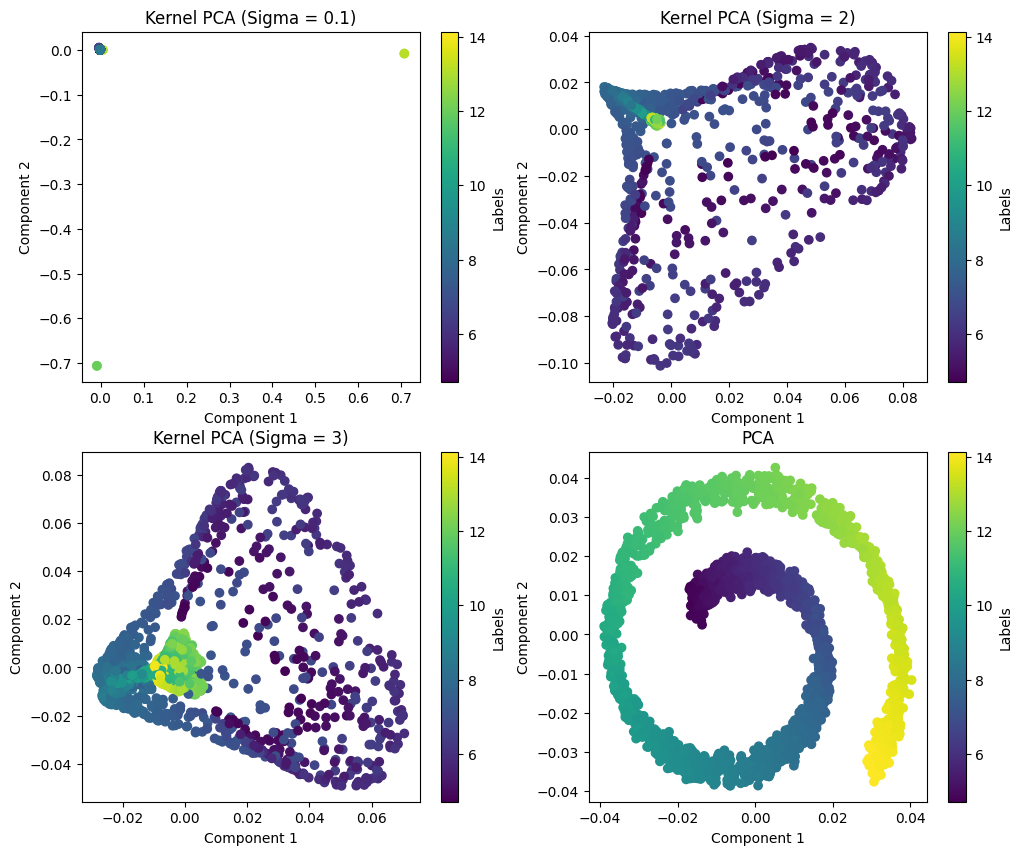

In [50]:
#visualizing the results


#Plot the results as a single figure
plt.figure(figsize=(12, 10))

# Plot Kernel PCA with sigma = 0.1
plt.subplot(2, 2, 1)
plt.scatter(X_kpca_sig1[:, 0], X_kpca_sig1[:, 1], c=Y_swiss)
plt.title(f"Kernel PCA (Sigma = {sig_list_swiss[0]})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

# Plot Kernel PCA with sigma = 1
plt.subplot(2, 2, 2)
plt.scatter(X_kpca_sig2[:, 0], X_kpca_sig2[:, 1], c=Y_swiss)
plt.title(f"Kernel PCA (Sigma = {sig_list_swiss[1]})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

# Plot Kernel PCA with sigma = 10
plt.subplot(2, 2, 3)
plt.scatter(X_kpca_sig3[:, 0], X_kpca_sig3[:, 1], c=Y_swiss)
plt.title(f"Kernel PCA (Sigma = {sig_list_swiss[2]})")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

# Plot regular PCA
plt.subplot(2, 2, 4)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y_swiss)
plt.title("PCA")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar(label="Labels")

plt.savefig('KPCA_swissSet.png',dpi=200)
